In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score
    , confusion_matrix, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

In [3]:
# Custom tokenizer using SpaCy
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

In [4]:
# Load the dataset from GitHub
url = "https://raw.githubusercontent.com/mohitgupta-1O1/Kaggle-SMS-Spam-Collection-Dataset-/9823a7f115df8caa24f7b3adfcc770526fbd07e3/spam.csv"

df = pd.read_csv(url, encoding='latin-1')

df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df = df[['label', 'message']]  # Keep only necessary columns

In [5]:
df.shape
df.head()
df.info()

(5572, 2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
# Encode labels (spam: 1, ham: 0)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

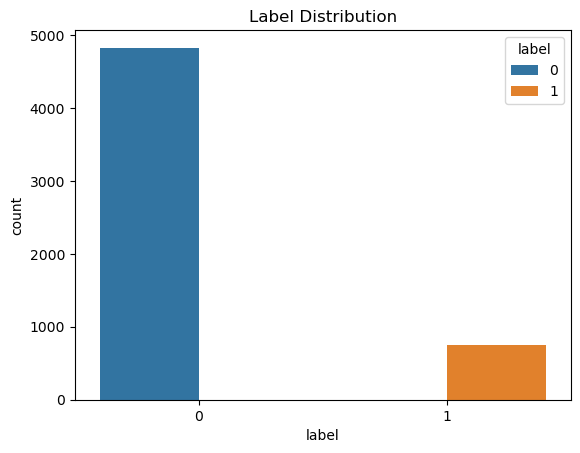

In [7]:
# Visualize label distribution
sns.countplot(
    x='label', data=df, hue='label'
)
plt.title("Label Distribution")
plt.show();

In [8]:
X = df['message']
y = df['label']

X.shape, y.shape

((5572,), (5572,))

In [9]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [10]:
# Vectorize text data using TfidfVectorizer (* with spaCy_tokenizer;)
tfidf = TfidfVectorizer(
    tokenizer=spacy_tokenizer, lowercase=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [16]:
X_train_tfidf.shape, X_test_tfidf.shape

X_train_tfidf

((4457, 7193), (1115, 7193))

<4457x7193 sparse matrix of type '<class 'numpy.float64'>'
	with 35701 stored elements in Compressed Sparse Row format>

In [18]:
# Initialize models for comparison
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=27
    ),
    'SVC': SVC(random_state=27),
    'LinearSVC': LinearSVC(
        max_iter=1000, random_state=27
    )
}

In [19]:
# Evaluate models
for name, model in models.items():
    
    model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} Accuracy: {accuracy:.4f}")

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


MultinomialNB Accuracy: 0.9605


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,27
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


LogisticRegression Accuracy: 0.9605


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVC Accuracy: 0.9776


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,27


LinearSVC Accuracy: 0.9848


In [20]:
# Select a base model (e.g., MultinomialNB) for hyperparameter tuning
# base_model = MultinomialNB()
help(LinearSVC())

Help on LinearSVC in module sklearn.svm._classes object:

class LinearSVC(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LinearSVC(penalty='l2', loss='squared_hinge', *, dual='auto', tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
 |  
 |  Linear Support Vector Classification.
 |  
 |  Similar to SVC with parameter kernel='linear', but implemented in terms of
 |  liblinear rather than libsvm, so it has more flexibility in the choice of
 |  penalties and loss functions and should scale better to large numbers of
 |  samples.
 |  
 |  The main differences between :class:`~sklearn.svm.LinearSVC` and
 |  :class:`~sklearn.svm.SVC` lie in the loss function used by default, and in
 |  the handling of intercept regularization between those two implementations.
 |  
 |  This class supports both dense and sparse input and th

In [42]:
# Set up hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.logspace(-2,2,17)
    , 'penalty': ['l2']  # 'l1' only works with 'liblinear' solver and 'dual=False'
    , 'loss': ['hinge', 'squared_hinge']
    , 'dual': ["auto"]  # For penalty='l2' and loss='squared_hinge', dual can be True or False
    , 'tol': [1e-4, 1e-3, 1e-2]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    base_model
    , param_grid
    , cv=5
    , scoring='accuracy'
)

grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='accuracy')

In [43]:
# Print best hyperparameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': 0.2}
Best Cross-Validation Accuracy: 0.9840686385529434


In [44]:
grid_search.best_params_

{'alpha': 0.2}

In [45]:
# Evaluate best model on test data
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test_tfidf)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9811659192825112


array([[955,   2],
       [ 19, 139]])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       957
           1       0.99      0.88      0.93       158

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



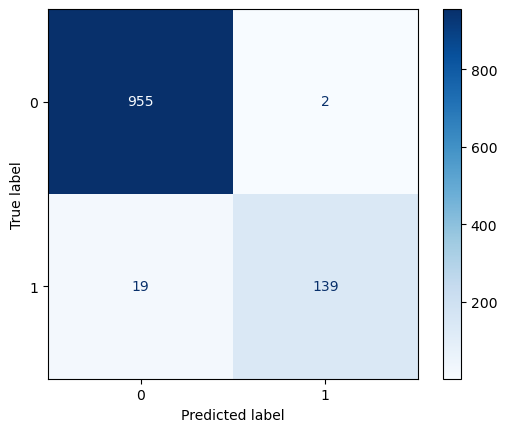

In [46]:
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_tfidf, y_test
    , cmap='Blues'
);

In [47]:
# Build a pipeline for testing on sample strings
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer=spacy_tokenizer, lowercase=True))
    , ('model', best_model)
])

In [50]:
# pipe.fit(df['text'],df['airline_sentiment'])
# data[['label', 'message']] 

# pipeline.fit(data['label'], data['message'])

pipeline.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('model', MultinomialNB(alpha=0.2))])

In [59]:
# Test pipeline on sample strings
sample_strings = [
    "Congratulations! You've won a free ticket to Bahamas.",
    "Hey, are we still on for lunch tomorrow?",
    "Urgent! Your account has been compromised. Click this link.",
    "Congratulations son! Your Mother is so proud!",
    "Enlarge your portfolio 1000% with my proven investment secrets!",
    "We should link up tomorrow!",
    "This airline sucks!"
]

predictions = pipeline.predict(sample_strings)

# Display predictions
for text, label in zip(sample_strings, predictions):
    print(f"Message: {text} -> Prediction: {'Spam' if label == 1 else 'Ham'}\n")

Message: Congratulations! You've won a free ticket to Bahamas. -> Prediction: Spam

Message: Hey, are we still on for lunch tomorrow? -> Prediction: Ham

Message: Urgent! Your account has been compromised. Click this link. -> Prediction: Spam

Message: Congratulations son! Your Mother is so proud! -> Prediction: Ham

Message: Enlarge your portfolio 1000% with my proven investment secrets! -> Prediction: Spam

Message: We should link up tomorrow! -> Prediction: Ham

Message: This airline sucks! -> Prediction: Ham



In [56]:
test = ["Urgent! Your account has been compromised. Click this link."]
pipeline.predict(test)

array([1])